In [281]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from empiricaldist import Pmf, Cdf

In [282]:
sensors = pd.read_csv('../data/XarxaSoroll_EquipsMonitor_Instal.csv')
sensors.head()

,Id_Instal,Codi_Carrer,Tipus_Via,Nom_Carrer,Num_Carrer,Codi_Barri,Nom_Barri,Codi_Districte,Nom_Districte,Latitud,Longitud,ETRS89_X,ETRS89_Y,Data_Instalacio,Data_DesInstalacio,Font
0,186,348408,C,Tuset,8,26,Galvany,5,Sarrià-Sant Gervasi,41.395450,2.152753,429172.441,4583003.592,29/01/2014,16/01/2015,OCI
1,187,348408,C,Tuset,17,26,Galvany,5,Sarrià-Sant Gervasi,41.396156,2.151564,429073.823,4583082.946,29/01/2014,16/01/2015,OCI
2,206,112208,C,Escudellers,53,2,el Barri Gòtic,1,Ciutat Vella,41.380127,2.176924,431177.000,4581283.000,05/02/2014,30/01/2015,OCI
3,207,86902,C,Nou de la Rambla,21,1,el Raval,1,Ciutat Vella,41.378273,2.173348,430876.000,4581080.000,05/02/2014,30/01/2015,OCI
4,208,46409,Pg,Born,19,4,"Sant Pere, Santa Caterina i la Ribera",1,Ciutat Vella,41.384925,2.182772,431671.000,4581811.000,05/02/2014,30/01/2015,OCI


In [283]:
noise_2020_1s = pd.read_csv('../data/2020_1S_XarxaSoroll_EqMonitor_Dades_1Hora.csv')
noise_2020_2s = pd.read_csv('../data/2020_2S_XarxaSoroll_EqMonitor_Dades_1Hora.csv')

noise_2021_1s = pd.read_csv('../data/2021_1S_XarxaSoroll_EqMonitor_Dades_1Hora.csv')
noise_2021_2s = pd.read_csv('../data/2021_2S_XarxaSoroll_EqMonitor_Dades_1Hora.csv')

df_2020 = pd.concat([noise_2020_1s, noise_2020_2s])
df_2021 = pd.concat([noise_2021_1s, noise_2021_2s])

df_2020.head()

,Any,Mes,Dia,Hora,Id_Instal,Nivell_LAeq_1h
0,2020,1,1,0:00,4388,72.0
1,2020,1,1,1:00,4388,51.4
2,2020,1,1,2:00,4388,50.2
3,2020,1,1,3:00,4388,50.4
4,2020,1,1,4:00,4388,48.7


In [284]:
noise_2020 = df_2020['Nivell_LAeq_1h']
noise_2021 = df_2021['Nivell_LAeq_1h']

Media de ruido en 2020: 60.689966055107185
Media de ruido en 2021: 61.568333113688716


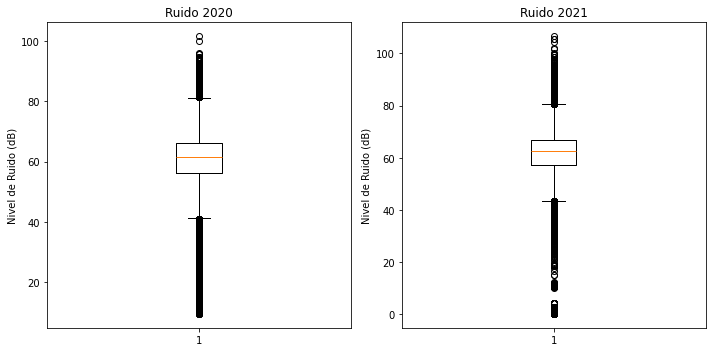

Estadístico t: -81.07737827712661
Valor p: 0.0
Hay una diferencia estadísticamente significativa en los niveles de ruido entre 2020 y 2021.


In [285]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Filtrar los datos relevantes (Nivell_LAeq_1h)
noise_2020 = df_2020['Nivell_LAeq_1h'].dropna()
noise_2021 = df_2021['Nivell_LAeq_1h'].dropna()

# Estadística descriptiva
print("Media de ruido en 2020:", noise_2020.mean())
print("Media de ruido en 2021:", noise_2021.mean())

# Boxplots para visualizar
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Boxplot 2020
axs[0].boxplot(noise_2020)
axs[0].set_title('Ruido 2020')
axs[0].set_ylabel('Nivel de Ruido (dB)')

# Boxplot 2021
axs[1].boxplot(noise_2021)
axs[1].set_title('Ruido 2021')
axs[1].set_ylabel('Nivel de Ruido (dB)')

plt.tight_layout()
plt.show()

# Prueba estadística: t-test
t_stat, p_value = ttest_ind(noise_2020, noise_2021, equal_var=False)
print("Estadístico t:", t_stat)
print("Valor p:", p_value)

# Interpretación
if p_value < 0.05:
    print("Hay una diferencia estadísticamente significativa en los niveles de ruido entre 2020 y 2021.")
else:
    print("No hay una diferencia estadísticamente significativa en los niveles de ruido entre 2020 y 2021.")


In [286]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

# Umbral de ruido
threshold = 65

# Conteo de valores por encima del umbral
x1 = (noise_2020 > threshold).sum()
x2 = (noise_2021 > threshold).sum()

# Tamaño total de cada muestra
n1 = len(noise_2020)
n2 = len(noise_2021)

# Prueba de proporciones
stat, p_value = proportions_ztest([x1, x2], [n1, n2])

# Resultados
print(f"Proporción en 2020: {x1 / n1:.2%}")
print(f"Proporción en 2021: {x2 / n2:.2%}")
print(f"Estadístico Z: {stat}")
print(f"Valor p: {p_value}")

# Interpretación
if p_value < 0.05:
    print("Hay una diferencia estadísticamente significativa en las proporciones de niveles de ruido por encima del umbral.")
else:
    print("No hay una diferencia estadísticamente significativa en las proporciones de niveles de ruido por encima del umbral.")


Proporción en 2020: 31.12%
Proporción en 2021: 34.84%
Estadístico Z: -55.23620053177345
Valor p: 0.0
Hay una diferencia estadísticamente significativa en las proporciones de niveles de ruido por encima del umbral.


In [287]:
import pandas as pd

df_2020['Hora'] = df_2020['Hora'].apply(lambda x: x[:-3]).astype(int)
df_2021['Hora'] = df_2021['Hora'].apply(lambda x: x[:-3]).astype(int)

# Agrupar por hora y calcular la media de ruido
noise_2020_by_hour = df_2020.groupby('Hora')['Nivell_LAeq_1h'].mean()
noise_2021_by_hour = df_2021.groupby('Hora')['Nivell_LAeq_1h'].mean()

# Calcular la diferencia promedio por hora
hourly_difference = noise_2021_by_hour - noise_2020_by_hour

# Identificar la franja horaria con el mayor cambio absoluto
max_change_hour = hourly_difference.abs().idxmax()
print(f"La franja horaria con el mayor cambio es: {max_change_hour}")
print(f"Diferencia promedio en esa franja: {hourly_difference[max_change_hour]:.2f} dB")

La franja horaria con el mayor cambio es: 16
Diferencia promedio en esa franja: 1.48 dB


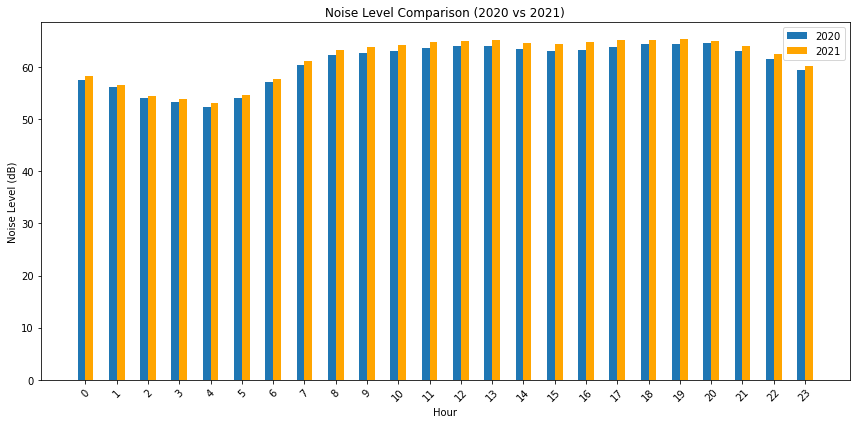

In [288]:
# Crear un rango para las posiciones
x = np.arange(len(noise_2020_by_hour.index))  # Índices de las horas

# Tamaño de las barras
bar_width = 0.25

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width/2, noise_2020_by_hour, width=bar_width, label='2020')
plt.bar(x + bar_width/2, noise_2021_by_hour, color='orange', width=bar_width, label='2021')

# Etiquetas y título
plt.xlabel('Hour')
plt.ylabel('Noise Level (dB)')
plt.title('Noise Level Comparison (2020 vs 2021)')
plt.xticks(x, noise_2020_by_hour.index, rotation=45)  # Etiquetas de las horas
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

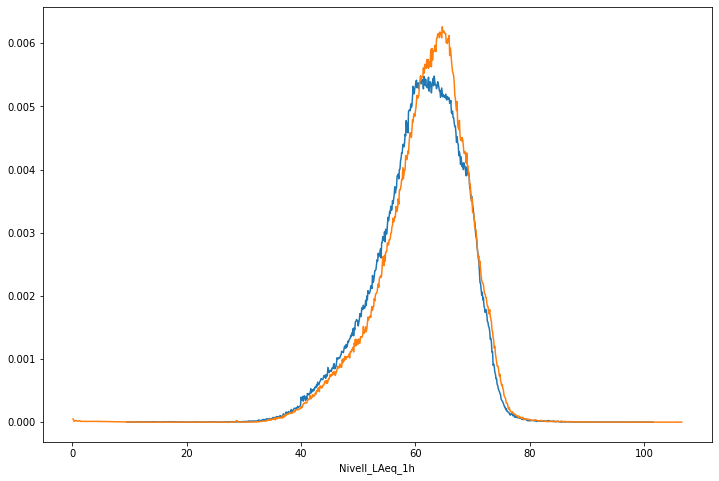

In [289]:
plt.figure(figsize=(12,8))
pmf_2020 = Pmf.from_seq(noise_2020)
pmf_2021 = Pmf.from_seq(noise_2021)
pmf_2020.plot()
pmf_2021.plot()
plt.show()

(<Axes: xlabel='Nivell_LAeq_1h'>, <Axes: xlabel='Nivell_LAeq_1h'>)

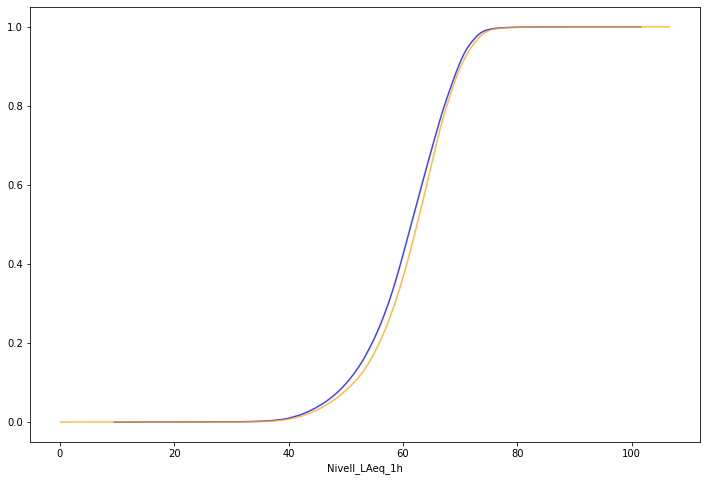

In [290]:
cdf_2020 = Cdf.from_seq(noise_2020)
cdf_2021 = Cdf.from_seq(noise_2021)

plt.figure(figsize=(12,8))
cdf_2020.plot(color='Blue', alpha=0.75), cdf_2021.plot(color='Orange', alpha=0.75)

In [291]:
max(noise_2020), max(noise_2021)

(101.6, 106.6)

In [292]:
from scipy.stats import ttest_ind

# Perform a two-tailed t-test
t_stat, p_value= ttest_ind(noise_2020, noise_2021, equal_var=False, alternative='less')

# Display the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: -81.07737827712661
P-value: 0.0


In [293]:
from scipy.stats import shapiro

ntA = shapiro(noise_2020)[1] < 0.05
ntB = shapiro(noise_2021)[1] < 0.05

ntA, ntB

/home/ivanseldasp/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 942999.
  res = hypotest_fun_out(*samples, **kwds)
/home/ivanseldasp/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1016794.
  res = hypotest_fun_out(*samples, **kwds)


(True, True)

In [294]:
from scipy.stats import shapiro, kstest

# Example: Shapiro-Wilk test for normality
stat, p = shapiro(noise_2021)
if p > 0.05:
    print("Data is normally distributed.")
else:
    print("Data is not normally distributed.")


Data is not normally distributed.


In [295]:
# A/B Testing Function - Quick Solution
def AB_Test(groupA, groupB):
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp
    
    
    
# Apply A/B Testing
AB_Test(noise_2020, noise_2021)

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,0.0,A/B groups are not similar!


## Chi-squared test

As a final example, let's consider a case where the choice of the test statistic takes some thought.
Suppose you run a casino and you suspect that a customer is using a crooked die -- that is, one that has been modified to make one of the faces more likely than the others.
You apprehend the alleged cheater and confiscate the die, but now you have to prove that it is crooked.
You roll the die 60 times and record the frequency of each outcome from 1 to 6.
Here are the results in a `Hist` object.

In [296]:
from empiricaldist import Hist

qs = np.arange(1, 7)
freqs = [8, 9, 19, 5, 8, 11]
observed = Hist(freqs, qs)
observed.index.name = "outcome"
observed

,freqs
outcome,
1,8
2,9
3,19
4,5
5,8
6,11


In [297]:
num_rolls = observed.sum()
outcomes = observed.qs
expected = Hist(num_rolls / 6, outcomes)
expected

,freqs
1,10.0
2,10.0
3,10.0
4,10.0
5,10.0
6,10.0


In [298]:
len(expected)

6

In [299]:
contingency_table = pd.DataFrame(zip(observed, expected), columns=['observed', 'expected'])
contingency_table

,observed,expected
0,8,10.0
1,9,10.0
2,19,10.0
3,5,10.0
4,8,10.0
5,11,10.0


In [300]:
contingency_table['t_stats'] = (contingency_table['observed'] - contingency_table['expected'])**2 / contingency_table['expected']
t_stat_total = sum(contingency_table['t_stats'])
print(t_stat_total)

df = len(observed) - 1

from scipy.stats import chi2

p_value = chi2.sf(t_stat_total, df)
p_value

11.6


0.040699388504049985

In [361]:
def die_simulation(observed):
    n_rounds = sum(observed)
    simulation = np.random.choice(np.arange(1, 7), n_rounds)
    hist = Hist.from_seq(simulation)
    return hist

simulation = die_simulation(observed)

def total_deviation(observed):
    return np.sum(np.abs(observed - expected))

simulated_devs = [total_deviation(die_simulation(observed)) for i in range(1001)]

In [364]:
simulated_devs

[20.0,
 12.0,
 8.0,
 10.0,
 12.0,
 16.0,
 10.0,
 6.0,
 10.0,
 6.0,
 14.0,
 4.0,
 12.0,
 6.0,
 10.0,
 12.0,
 16.0,
 18.0,
 16.0,
 16.0,
 20.0,
 14.0,
 8.0,
 12.0,
 20.0,
 8.0,
 14.0,
 6.0,
 14.0,
 6.0,
 22.0,
 4.0,
 14.0,
 8.0,
 18.0,
 12.0,
 12.0,
 18.0,
 16.0,
 18.0,
 20.0,
 12.0,
 16.0,
 10.0,
 8.0,
 14.0,
 16.0,
 16.0,
 10.0,
 14.0,
 8.0,
 12.0,
 8.0,
 14.0,
 14.0,
 14.0,
 14.0,
 8.0,
 12.0,
 12.0,
 8.0,
 4.0,
 16.0,
 18.0,
 10.0,
 6.0,
 16.0,
 12.0,
 14.0,
 16.0,
 8.0,
 10.0,
 4.0,
 20.0,
 12.0,
 12.0,
 22.0,
 14.0,
 22.0,
 18.0,
 14.0,
 22.0,
 18.0,
 14.0,
 22.0,
 10.0,
 20.0,
 6.0,
 12.0,
 22.0,
 16.0,
 14.0,
 8.0,
 20.0,
 12.0,
 12.0,
 14.0,
 12.0,
 6.0,
 14.0,
 10.0,
 18.0,
 14.0,
 10.0,
 14.0,
 20.0,
 14.0,
 16.0,
 14.0,
 14.0,
 6.0,
 12.0,
 18.0,
 12.0,
 14.0,
 16.0,
 16.0,
 14.0,
 16.0,
 8.0,
 10.0,
 16.0,
 12.0,
 12.0,
 18.0,
 16.0,
 14.0,
 14.0,
 16.0,
 16.0,
 12.0,
 18.0,
 12.0,
 10.0,
 10.0,
 14.0,
 4.0,
 14.0,
 16.0,
 14.0,
 18.0,
 10.0,
 10.0,
 4.0,
 10.0,
 18.0,
 14.0

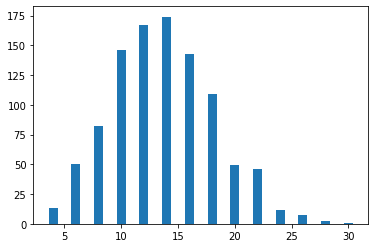

In [365]:
simulated_devs_hist = Hist.from_seq(simulated_devs)
simulated_devs_hist.bar()

In [369]:
def compute_pvalue(simulated, observed):
    return (np.asarray(simulated) >= observed).mean()

observed_dev = total_deviation(observed)
print(observed_dev)

p_value = compute_pvalue(simulated_devs, observed_dev)
p_value

20.0


0.11688311688311688

In [357]:
from scipy.stats import chi2_contingency

# Crear una tabla de contingencia
contingency_table = pd.crosstab(observed, expected)

# Aplicar el Chi-Square Test
chi2, p, dof, expected = chi(contingency_table)

# Resultados
print("Tabla de Contingencia:\n", contingency_table)
print(f"\nChi-Square Statistic: {chi2:.2f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-Value: {p:.4f}")

NameError: name 'chi' is not defined

In [219]:
contingency_table

col_0,10.0
row_0,
5,1
8,2
9,1
11,1
19,1
